## Loading Data

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [8]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

## Training and Testing Utils

In [29]:
import time
from tqdm import tqdm

In [30]:
def train_model(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            predicted = outputs.argmax(dim=1)
            train_corrects += (predicted == labels).sum().item()
    
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    end_time = time.time()

    print(f'Finished Training. Total training time: {end_time - start_time:.2f} seconds.')

    return train_loss_history, train_accuracy_history

## Loading Models

In [36]:
from models import lnn, cnn, transformer
from matplotlib import pyplot as plt

In [43]:
lnn_model = lnn.LNN(32 * 32 * 3, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  33475330


In [44]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.001)

train_loss_history, train_accuracy_history = train_model(lnn_model, train_loader, criterion, optimizer, epochs=50, device='cuda')

Epoch 1/50: 100%|██████████| 1563/1563 [00:39<00:00, 39.99it/s]


Train Loss: 1.7438, Train Accuracy: 0.3781


Epoch 2/50: 100%|██████████| 1563/1563 [00:36<00:00, 42.76it/s]


Train Loss: 1.5241, Train Accuracy: 0.4649


Epoch 3/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.49it/s]


Train Loss: 1.4197, Train Accuracy: 0.4998


Epoch 4/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.46it/s]


Train Loss: 1.3348, Train Accuracy: 0.5301


Epoch 5/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.49it/s]


Train Loss: 1.2590, Train Accuracy: 0.5576


Epoch 6/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.59it/s]


Train Loss: 1.1985, Train Accuracy: 0.5798


Epoch 7/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.58it/s]


Train Loss: 1.1284, Train Accuracy: 0.6035


Epoch 8/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.54it/s]


Train Loss: 1.0720, Train Accuracy: 0.6236


Epoch 9/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.49it/s]


Train Loss: 1.0141, Train Accuracy: 0.6459


Epoch 10/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.53it/s]


Train Loss: 0.9515, Train Accuracy: 0.6647


Epoch 11/50: 100%|██████████| 1563/1563 [00:36<00:00, 43.16it/s]


Train Loss: 0.9020, Train Accuracy: 0.6861


Epoch 12/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.47it/s]


Train Loss: 0.8512, Train Accuracy: 0.7011


Epoch 13/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.51it/s]


Train Loss: 0.8086, Train Accuracy: 0.7194


Epoch 14/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.53it/s]


Train Loss: 0.7688, Train Accuracy: 0.7320


Epoch 15/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.57it/s]


Train Loss: 0.7289, Train Accuracy: 0.7491


Epoch 16/50: 100%|██████████| 1563/1563 [00:35<00:00, 43.57it/s]


Train Loss: 0.6960, Train Accuracy: 0.7575


Epoch 17/50: 100%|██████████| 1563/1563 [00:45<00:00, 34.64it/s]


Train Loss: 0.6685, Train Accuracy: 0.7704


Epoch 18/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.19it/s]


Train Loss: 0.6410, Train Accuracy: 0.7811


Epoch 19/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.64it/s]


Train Loss: 0.6145, Train Accuracy: 0.7895


Epoch 20/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.70it/s]


Train Loss: 0.5942, Train Accuracy: 0.7972


Epoch 21/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.95it/s]


Train Loss: 0.5695, Train Accuracy: 0.8076


Epoch 22/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.96it/s]


Train Loss: 0.5362, Train Accuracy: 0.8193


Epoch 23/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.89it/s]


Train Loss: 0.5247, Train Accuracy: 0.8236


Epoch 24/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.79it/s]


Train Loss: 0.5110, Train Accuracy: 0.8281


Epoch 25/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.94it/s]


Train Loss: 0.4995, Train Accuracy: 0.8335


Epoch 26/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.65it/s]


Train Loss: 0.4688, Train Accuracy: 0.8441


Epoch 27/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.01it/s]


Train Loss: 0.4726, Train Accuracy: 0.8437


Epoch 28/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.25it/s]


Train Loss: 0.4420, Train Accuracy: 0.8555


Epoch 29/50: 100%|██████████| 1563/1563 [00:44<00:00, 35.48it/s]


Train Loss: 0.4329, Train Accuracy: 0.8579


Epoch 30/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.06it/s]


Train Loss: 0.4244, Train Accuracy: 0.8599


Epoch 31/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.10it/s]


Train Loss: 0.4259, Train Accuracy: 0.8620


Epoch 32/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.29it/s]


Train Loss: 0.4060, Train Accuracy: 0.8669


Epoch 33/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.12it/s]


Train Loss: 0.4037, Train Accuracy: 0.8695


Epoch 34/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.22it/s]


Train Loss: 0.3839, Train Accuracy: 0.8759


Epoch 35/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.25it/s]


Train Loss: 0.3797, Train Accuracy: 0.8794


Epoch 36/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.04it/s]


Train Loss: 0.3929, Train Accuracy: 0.8760


Epoch 37/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.08it/s]


Train Loss: 0.3648, Train Accuracy: 0.8851


Epoch 38/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.09it/s]


Train Loss: 0.3654, Train Accuracy: 0.8829


Epoch 39/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.06it/s]


Train Loss: 0.3517, Train Accuracy: 0.8903


Epoch 40/50: 100%|██████████| 1563/1563 [00:44<00:00, 35.50it/s]


Train Loss: 0.3483, Train Accuracy: 0.8889


Epoch 41/50: 100%|██████████| 1563/1563 [00:43<00:00, 35.80it/s]


Train Loss: 0.3644, Train Accuracy: 0.8868


Epoch 42/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.15it/s]


Train Loss: 0.3247, Train Accuracy: 0.8982


Epoch 43/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.16it/s]


Train Loss: 0.3452, Train Accuracy: 0.8924


Epoch 44/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.14it/s]


Train Loss: 0.3265, Train Accuracy: 0.8999


Epoch 45/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.15it/s]


Train Loss: 0.3483, Train Accuracy: 0.8947


Epoch 46/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.18it/s]


Train Loss: 0.3043, Train Accuracy: 0.9050


Epoch 47/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.02it/s]


Train Loss: 0.3137, Train Accuracy: 0.9038


Epoch 48/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.10it/s]


Train Loss: 0.3282, Train Accuracy: 0.8986


Epoch 49/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.08it/s]


Train Loss: 0.3227, Train Accuracy: 0.9030


Epoch 50/50: 100%|██████████| 1563/1563 [00:43<00:00, 36.19it/s]

Train Loss: 0.3066, Train Accuracy: 0.9071
Finished Training. Total training time: 2056.51 seconds.


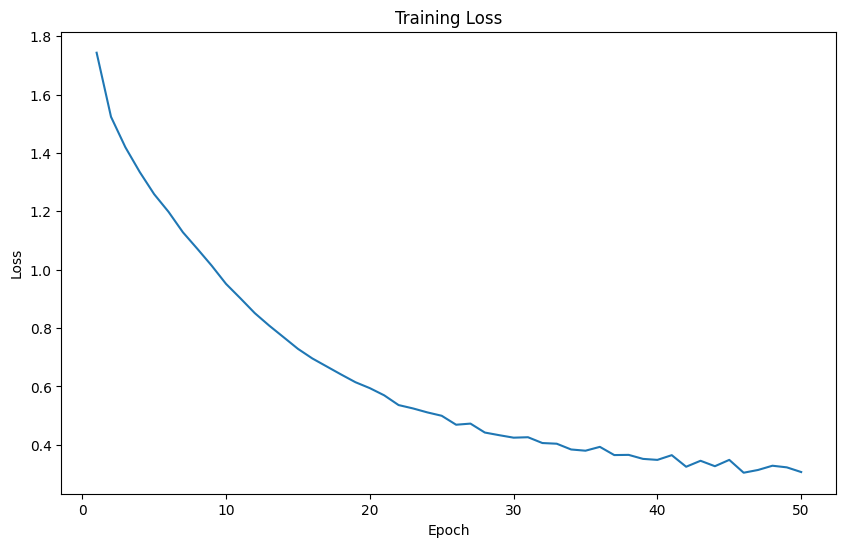

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

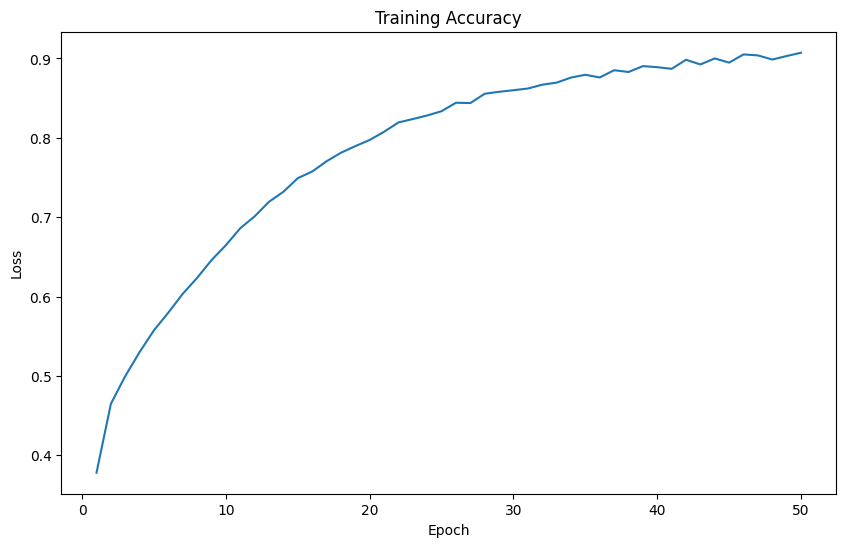

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [5]:
cnn_model = cnn.CNN(3, num_classes=10)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  1107538


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

train_loss_history = train_model(cnn_model, train_loader, criterion, optimizer, epochs=10, device='cuda')